# dACC ISRSA in task debate

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pymer4.models import Lmer

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from nltools.data import Adjacency
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform


In [2]:

def regress_out(vec, control_matrices):
    # 获取上三角部分的索引
    upper_triangle_indices = np.triu_indices_from(vec, k=1)

    if control_matrices is None or len(control_matrices) == 0:
        return vec  # 如果没有控制变量，直接返回原始矩阵

    # 对原始矩阵进行标准化
    scaler = StandardScaler()
    vec_scaled = scaler.fit_transform(vec[upper_triangle_indices].reshape(-1, 1)).flatten()

    # 收集控制变量的标准化版本
    control_vectors = []
    for control_matrix in control_matrices:
        control_vec = control_matrix[upper_triangle_indices]
        control_vec_scaled = scaler.fit_transform(control_vec.reshape(-1, 1)).flatten()
        control_vectors.append(control_vec_scaled)
    
    # 拼接控制变量矩阵
    control_matrix = np.column_stack(control_vectors)

    # 执行回归
    model = LinearRegression().fit(control_matrix, vec_scaled)

    # 计算残差
    residuals = vec_scaled - model.predict(control_matrix)
    
    # 将残差放回原始矩阵的上三角部分
    vec_residual = np.zeros_like(vec)
    vec_residual[upper_triangle_indices] = residuals

    # 由于矩阵是对称的，将残差填充回下三角部分
    vec_residual = vec_residual + vec_residual.T

    return vec_residual


In [5]:

base_dir = '/Users/li/Desktop/debate/braindata'

sub_list = [f'sub-{x:0>3d}' for x in range(13,51)]
sub_list.remove('sub-021')

subs_roi_data = []
for sub in sub_list:
    csv_file = f'/Volumes/Li/task-debate/braindata/denoised 5/parcel data/Schaefer 200 combine 6 runs/{sub}_combined_time-series_Schaefer2018_200Parcels_7Networks.csv'
    sub_data = pd.read_csv(csv_file)
    subs_roi_data.append(sub_data.values)

all_brain_data = np.array(subs_roi_data)
print(all_brain_data.shape)

brain_correlation_matrices = []
for node in range(all_brain_data.shape[2]):
    brain_correlation_matrices.append(Adjacency(1 - pairwise_distances(all_brain_data[:, :, node], metric='correlation'), matrix_type='similarity'))
brain_ISC = Adjacency(brain_correlation_matrices)
brain_ISC_np = np.array(brain_ISC.squareform())
print(brain_ISC_np.shape)
brain_ISC_Z_np = np.arctanh(brain_ISC_np)


(37, 1493, 200)
(200, 37, 37)


In [7]:
bahav_data_dir = '/Users/li/Desktop/task-debate/behavdata'

sub_list_num = list(range(13,51))
sub_list_num.remove(21)

# time_points = list(range(0,3000,60)) + [2986]  # every 1 minute
time_points = list(range(0,3000,120)) + [2986] # every 2 min
# time_points = list(range(0,3000,300)) + [2986] # every 5 min
# time_points = [0, 252, 500, 772, 1098, 1484, 1892, 2464, 2986] # every speaker
# time_points = list(range(0,2987,2)) # every TR


all_subject_data = []
for sub in sub_list_num:
    file_path = os.path.join(bahav_data_dir, 'during_scan', 'combined_6runs_per_TR_filter', f'subject_{sub}_TR_rate.csv')
    
    df = pd.read_csv(file_path)
    sub_data = df[df['time'].isin(time_points)]
    all_subject_data.append(list(sub_data['rate']))
    
attitude = pd.DataFrame(all_subject_data)

start_attitude = pd.DataFrame(attitude)[0]
start_attitude_SM = -np.abs(start_attitude.values[:, np.newaxis] - start_attitude.values)

attitude_change = attitude.diff(axis=1)
attitude_change = attitude_change.drop(attitude_change.columns[0], axis=1)
print(attitude_change.shape)

attitude_change_distances = -pdist(attitude_change)
# attitude_change_distances = -np.sqrt(pdist(attitude_change))
# attitude_change_distances = -np.log(pdist(attitude_change))
attitude_change_distances_matrix = squareform(attitude_change_distances)
print(attitude_change_distances_matrix.shape)




(37, 25)
(37, 37)


In [23]:
dACC_NS = brain_ISC_Z_np[97,:,:]
SM2min = attitude_change_distances_matrix

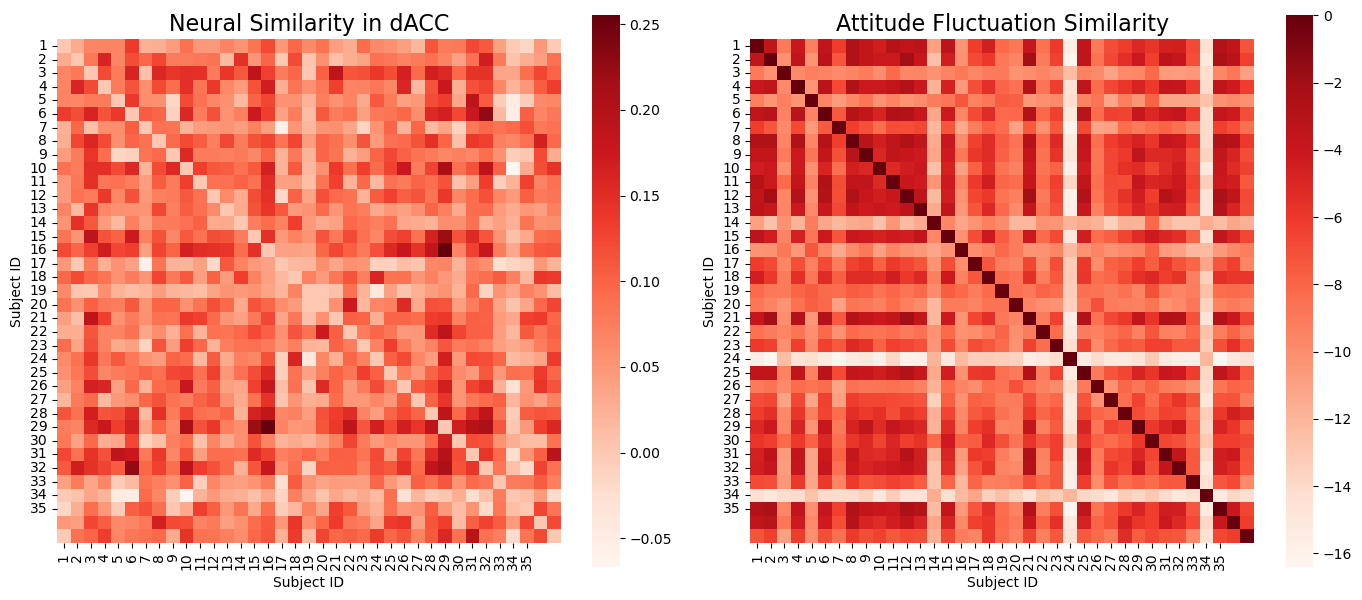

In [25]:

# 创建画布
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 绘制热图
sns.heatmap(dACC_NS, cmap='Reds', annot=False, square=True, xticklabels=np.arange(1, 36), 
            yticklabels=np.arange(1, 36), ax=axes[0])
axes[0].set_title("Neural Similarity in dACC",fontsize=16)
axes[0].set_xlabel("Subject ID")
axes[0].set_ylabel("Subject ID")


# 绘制热图
sns.heatmap(SM2min, cmap='Reds', annot=False, square=True, xticklabels=np.arange(1, 36), 
            yticklabels=np.arange(1, 36), ax=axes[1])
axes[1].set_title("Attitude Fluctuation Similarity",fontsize=16)
axes[1].set_xlabel("Subject ID")
axes[1].set_ylabel("Subject ID")

# 调整布局
plt.tight_layout()
# plt.savefig("Exp_1_Inter-subjects Attitude Change Similarity.png", dpi=300, bbox_inches='tight')
plt.show()

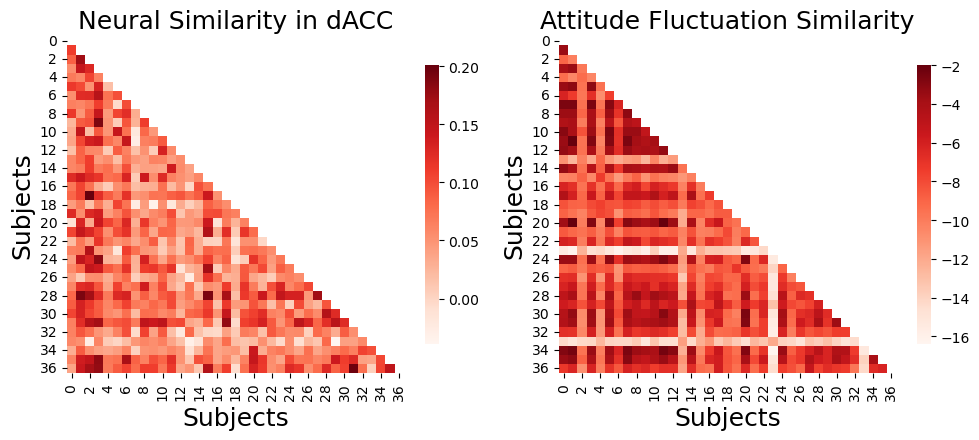

In [17]:

# 生成示例数据（替换为你的 dACC_NS 和 SM2min）
size = 37  

# 创建下三角 mask（True 表示隐藏）
mask = np.triu(np.ones_like(dACC_NS, dtype=bool))  # 只显示下三角

# 创建画布
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 绘制 dACC_NS 热图（只显示下三角）
sns.heatmap(dACC_NS, cmap='Reds', annot=False, square=True, mask=mask, ax=axes[0], cbar_kws={"shrink": 0.6})

axes[0].set_title("Neural Similarity in dACC", fontsize=18)
axes[0].set_xlabel("Subjects", fontsize=18)
axes[0].set_ylabel("Subjects", fontsize=18)

# # 绘制 SM2min 热图（只显示下三角）
# sns.heatmap(SM2min, cmap='Reds', annot=False, square=True, xticklabels=np.arange(1, size+1),
#             yticklabels=np.arange(1, size+1), mask=mask, ax=axes[1])

sns.heatmap(SM2min, cmap='Reds', annot=False, square=True, mask=mask, 
            ax=axes[1], cbar_kws={"shrink": 0.6})
axes[1].set_title("Attitude Fluctuation Similarity", fontsize=18)
axes[1].set_xlabel("Subjects", fontsize=18)
axes[1].set_ylabel("Subjects", fontsize=18)

# 调整布局
plt.tight_layout()
# plt.savefig("Exp_1_ISRAS_dACC.png", dpi=300, bbox_inches='tight')
plt.show()


In [15]:

def regress_out(vec, control_matrices):
    # 获取上三角部分的索引
    upper_triangle_indices = np.triu_indices_from(vec, k=1)

    if control_matrices is None or len(control_matrices) == 0:
        return vec  # 如果没有控制变量，直接返回原始矩阵

    # 对原始矩阵进行标准化
    scaler = StandardScaler()
    vec_scaled = scaler.fit_transform(vec[upper_triangle_indices].reshape(-1, 1)).flatten()

    # 收集控制变量的标准化版本
    control_vectors = []
    for control_matrix in control_matrices:
        control_vec = control_matrix[upper_triangle_indices]
        control_vec_scaled = scaler.fit_transform(control_vec.reshape(-1, 1)).flatten()
        control_vectors.append(control_vec_scaled)
    
    # 拼接控制变量矩阵
    control_matrix = np.column_stack(control_vectors)

    # 执行回归
    model = LinearRegression().fit(control_matrix, vec_scaled)

    # 计算残差
    residuals = vec_scaled - model.predict(control_matrix)
    
    # 将残差放回原始矩阵的上三角部分
    vec_residual = np.zeros_like(vec)
    vec_residual[upper_triangle_indices] = residuals

    # 由于矩阵是对称的，将残差填充回下三角部分
    vec_residual = vec_residual + vec_residual.T

    return vec_residual


In [17]:

subjects = list(range(13,51))
subjects.remove(21)

personality = pd.read_csv('/Users/li/Desktop/task-debate/behavdata/questionire_data/personality.csv')

selected_data = personality[personality['sub'].isin(subjects)]
selected_data = selected_data.set_index('sub').loc[subjects]

ages = selected_data['age'].values
age_diff_matrix = np.abs(ages[:, np.newaxis] - ages)

sex = selected_data['sex'].values
sex_diff_matrix = np.abs(sex[:, np.newaxis] - sex)

IUS = selected_data['IUS'].values
joint_IUS = (IUS[:, np.newaxis] + IUS)/2



In [19]:
dACC_NS_reg = regress_out(brain_ISC_Z_np[89,:,:], [start_attitude_SM,age_diff_matrix,sex_diff_matrix])
SM2min_reg = regress_out(attitude_change_distances_matrix, [start_attitude_SM,age_diff_matrix,sex_diff_matrix])



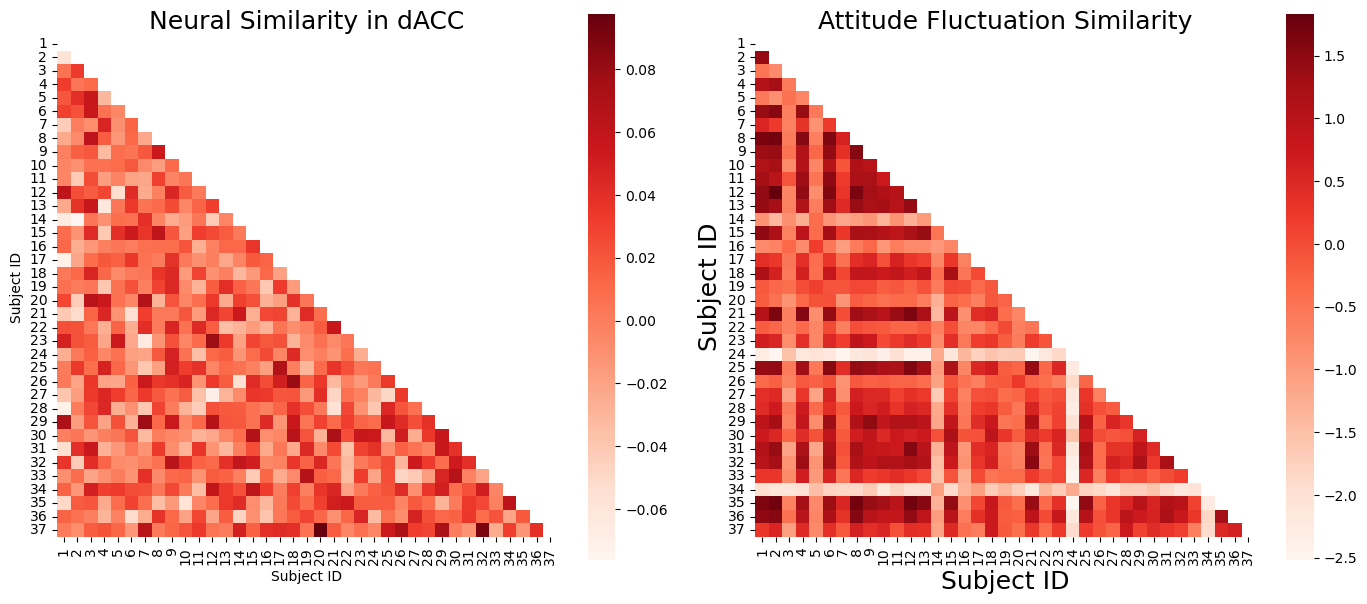

In [21]:

# 生成示例数据（替换为你的 dACC_NS 和 SM2min）
size = 37  

# 创建下三角 mask（True 表示隐藏）
mask = np.triu(np.ones_like(brain_ISC_Z_np[57,:,:], dtype=bool))  # 只显示下三角

# 创建画布
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 绘制 dACC_NS 热图（只显示下三角）
sns.heatmap(brain_ISC_Z_np[57,:,:], cmap='Reds', annot=False, square=True, xticklabels=np.arange(1, size+1),
            yticklabels=np.arange(1, size+1), mask=mask, ax=axes[0])
axes[0].set_title("Neural Similarity in dACC", fontsize=18)
axes[0].set_xlabel("Subject ID")
axes[0].set_ylabel("Subject ID")

# 绘制 SM2min 热图（只显示下三角）
sns.heatmap(SM2min_reg, cmap='Reds', annot=False, square=True, xticklabels=np.arange(1, size+1),
            yticklabels=np.arange(1, size+1), mask=mask, ax=axes[1])
axes[1].set_title("Attitude Fluctuation Similarity", fontsize=18)
axes[1].set_xlabel("Subject ID", fontsize=18)
axes[1].set_ylabel("Subject ID", fontsize=18)

# 调整布局
plt.tight_layout()
# plt.savefig("Exp_1_ISRAS_dACC.png", dpi=300, bbox_inches='tight')
plt.show()


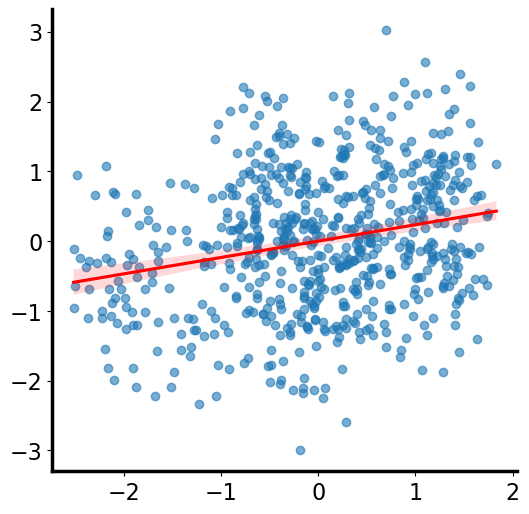

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 生成示例数据（替换为你的数据）
size = 37

# 获取矩阵的上三角元素（去除对角线）
triu_indices = np.triu_indices_from(SM2min_reg, k=1)
A_triu = SM2min_reg[triu_indices]
B_triu = dACC_NS_reg[triu_indices]

# 计算皮尔逊相关系数
corr, p_value = pearsonr(A_triu, B_triu)

# 绘制散点图 + 回归线
plt.figure(figsize=(6, 6))
sns.regplot(x=A_triu, y=B_triu, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'}, ci=95)

# 添加标签和标题
# plt.xlabel("Attitude Fluctuation Similarity", fontsize=18)
# plt.ylabel("Neural Similarity in dACC", fontsize=18)
# plt.title(f"Inter-segment Correlation: r={corr:.3f}, p={p_value:.3f}", fontsize=14)

# 调整外观
plt.gca().spines['top'].set_visible(False)  # 去掉上框线
plt.gca().spines['right'].set_visible(False)  # 去掉右框线
plt.gca().spines['left'].set_linewidth(2.5)  # 设置左框线宽度
plt.gca().spines['bottom'].set_linewidth(2.5)  # 设置下框线宽度
# plt.savefig("Exp_1_ISRAS_dACC_corr.png", dpi=300, bbox_inches='tight')
plt.xticks(fontsize=16)  # 设置 x 轴刻度字体大小
plt.yticks(fontsize=16)  # 设置 y 轴刻度字体大小

plt.savefig('/Users/li/Desktop/Figure/4c.png', dpi=300)
# 显示图像
plt.show()


In [27]:
pearsonr(A_triu, B_triu)

PearsonRResult(statistic=0.23586552391575172, pvalue=7.151589295557224e-10)

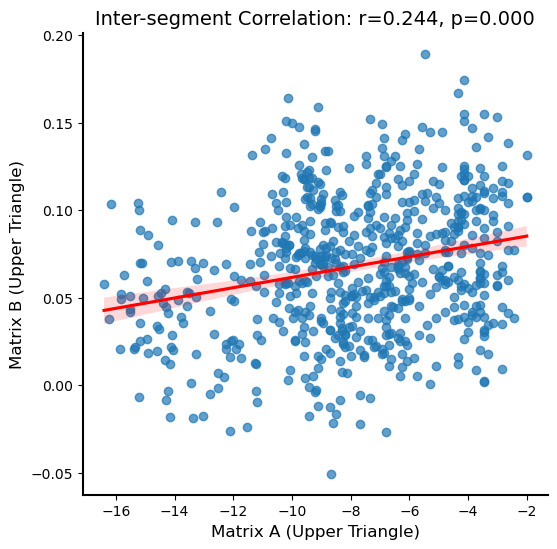

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 生成示例数据（替换为你的数据）
size = 37

# 获取矩阵的上三角元素（去除对角线）
triu_indices = np.triu_indices_from(SM2min_reg, k=1)
A_triu = SM2min[triu_indices]
B_triu = dACC_NS[triu_indices]

# 计算皮尔逊相关系数
corr, p_value = pearsonr(A_triu, B_triu)

# 绘制散点图 + 回归线
plt.figure(figsize=(6, 6))
sns.regplot(x=A_triu, y=B_triu, scatter_kws={'alpha': 0.7}, line_kws={'color': 'red'}, ci=95)

# 添加标签和标题
plt.xlabel("Matrix A (Upper Triangle)", fontsize=12)
plt.ylabel("Matrix B (Upper Triangle)", fontsize=12)
plt.title(f"Inter-segment Correlation: r={corr:.3f}, p={p_value:.3f}", fontsize=14)

# 调整外观
plt.gca().spines['top'].set_visible(False)  # 去掉上框线
plt.gca().spines['right'].set_visible(False)  # 去掉右框线
plt.gca().spines['left'].set_linewidth(1.5)  # 设置左框线宽度
plt.gca().spines['bottom'].set_linewidth(1.5)  # 设置下框线宽度

# 显示图像
plt.show()
